In [1]:

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from dataset import *
from models import *
from trainAndTest import *

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
microglia = sc.read_h5ad('../data/rosmap/microglia.h5ad')

In [2]:
metadata = pd.read_csv('../data/rosmap/rosmap_clinical.csv')

In [3]:
columns = [
        "individualID", "braaksc", "ceradsc", "cogdx", "msex", "age_at_visit_max", "apoe_genotype", "pmi"
    ]

# columns2 = [
#     "individualID", "braaksc", "ceradsc", "age_at_visit_max"
# ]
# Select and clean relevant metadata
metadata = metadata[columns].dropna()
metadata = metadata[metadata["pmi"] < 12]
metadata = metadata[metadata["cogdx"] != 6]
metadata["cogdx"] = metadata["cogdx"].astype(int) - 1
metadata["ceradsc"] = metadata["ceradsc"].astype(int) - 1
metadata["braaksc"] = metadata["braaksc"].replace({0: 0, 1: 0, 2: 0, 3: 1, 4: 2, 5: 3, 6: 3})
metadata["cogdx"] = metadata["cogdx"].replace({0: 0, 1: 1, 2: 1, 3: 2, 4: 2})
metadata["age_at_visit_max"] = metadata["age_at_visit_max"].replace({"90+": 90.0})
# replace the strings in age_at_visit_max with their float parsed values
metadata["age_at_visit_max"] = metadata["age_at_visit_max"].astype(float)
print(metadata["age_at_visit_max"].std())

braakdict = dict(zip(metadata["individualID"], metadata["braaksc"]))
ceraddict = dict(zip(metadata["individualID"], metadata["ceradsc"]))
cogdxdict = dict(zip(metadata["individualID"], metadata["cogdx"]))

4.556056760640835


In [20]:
microglia = microglia[microglia.obs["individualID"].isin(metadata["individualID"])]

In [5]:
stateDict = {
            "Mic.1": 0,
            "Mic.2": 1,
            "Mic.3": 2,
            "Mic.4": 3,
            "Mic.5": 4,
            "Mic.6": 5,
            "Mic.7": 6,
            "Mic.8": 7,
            "Mic.9": 8,
            "Mic.10": 9,
            "Mic.11": 10,
            "Mic.12": 11,
            "Mic.13": 12,
            "Mic.14": 13,
            "Mic.15": 14,
            "Mic.16": 15,
            "Macrophages": 16,
            "Monocytes": 17
        }

In [6]:
modelList = []
for i in range(5):
    model = MultiTaskModel(input_dim=1000, num_classes_list=[4, 4, 3, 18], task_types=["coral", "coral", "coral",  "classification"])
    model.load_state_dict(torch.load(f'allTasks/models/{i+1}_CTmodel.pth'))
    modelList.append(model)


In [7]:
microglia.obs["state"] = microglia.obs["state"].map(stateDict)

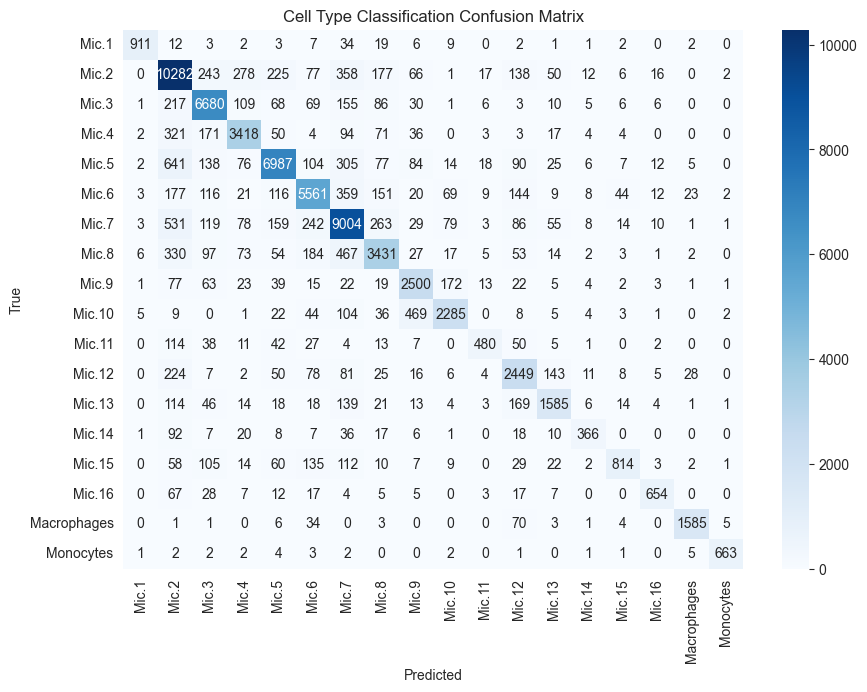

In [8]:
pred = []
true = []
for i in range(5):
    indices = np.loadtxt(f'allTasks/data/{i+1}_CTindices.txt', dtype=int)
    ids = np.loadtxt(f'allTasks/data/{i+1}_CTtestIds.txt', dtype=str)
    model = modelList[i]
    model.eval()
    adata_subset = microglia[:, indices]
    adata_subset = adata_subset[adata_subset.obs["individualID"].isin(ids)]
    X_test = adata_subset.X
    
    output = model(torch.tensor(X_test, dtype=torch.float32))
    preds = output[3].argmax(dim=1)
    pred.extend(preds.numpy())
    true.extend(adata_subset.obs["state"].values)
    del adata_subset, X_test, output

plot_confusion_matrix(true, pred, classes=list(stateDict.keys()), title='Cell Type Classification Confusion Matrix')


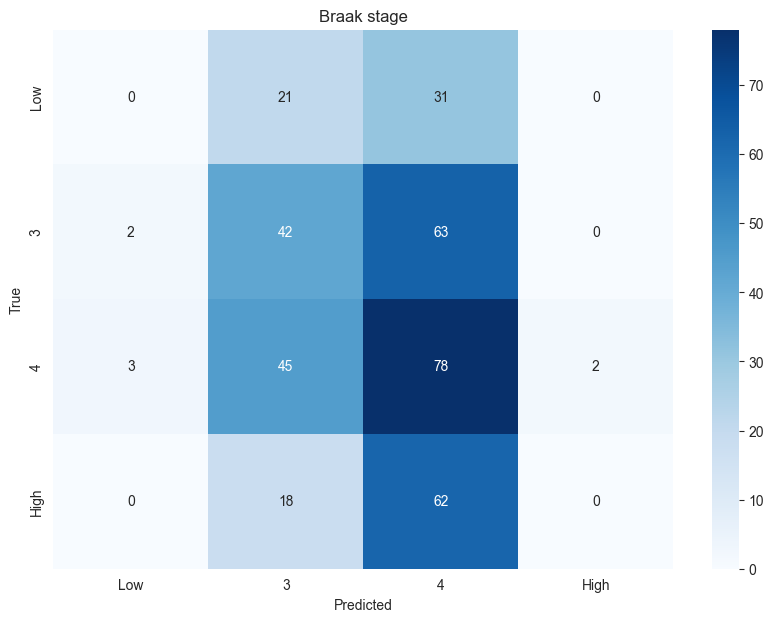

In [8]:
#BRAAK
from collections import Counter

correctCells = []
totalCells = []
braakScoreCells = []

pred = []
true = []

for i in range(5):
    indices = np.loadtxt(f'allTasks/data/{i+1}_CTindices.txt', dtype=int)
    ids = np.loadtxt(f'allTasks/data/{i+1}_CTtestIds.txt', dtype=str)
    model = modelList[i]
    model.eval()
    adata_subset = microglia[:, indices]
    adata_subset = adata_subset[adata_subset.obs["individualID"].isin(ids)]
    X_test = adata_subset.X

    for id in ids:
        cells = adata_subset[adata_subset.obs["individualID"] == id]
        cellTensor = torch.tensor(cells.X, dtype=torch.float32)
        braaksc = braakdict[id]
        true.append(braaksc)
        cell_types = cells.obs["state"].values
        
        
        with torch.no_grad():
            output = model(cellTensor)
            pred_class = (output[1] > 0.5).sum(dim=1).numpy()
            pred_cells = output[3].argmax(dim=1).numpy()
        
        classCounts = dict(Counter(pred_class))
        if braaksc in classCounts.keys():
            predMax = classCounts[braaksc]
        else:
            predMax = 0
        #predMax = classCounts[braaksc]
        guess = max(classCounts, key=classCounts.get)
        
        if guess in classCounts.keys():
            guessCount = classCounts[guess]
        else:
            guessCount = 0
        total = sum(classCounts.values())
        
        #create mask of for which cells braak score is precicted correctly
        mask = (pred_class == braaksc)
        
        pred.append(guess)
        
        cellacc = (pred_cells == cell_types).sum()
        if guess == braaksc:
    
            # print(f"ID: {id}, Braak score: {braaksc}, Predicted score: {guess}, Count: {predMax}/{total} ({predMax/total:.2%}), Cell type accuracy: {cellacc}/{len(cell_types)} ({cellacc/len(cell_types):.2%})")
            
    
            correctCells.extend(pred_cells)
        braakScoreCells.extend(pred_cells[mask])
        totalCells.extend(pred_cells)
    del adata_subset, X_test, cellTensor, output, pred_class, pred_cells 
plot_confusion_matrix(true, pred, ["Low", "3", "4", "High"], "Braak stage")

# correctCounts = pd.Series(correctCells).value_counts()
# totalCounts = pd.Series(totalCells).value_counts()
# braakScoreCounts = pd.Series(braakScoreCells).value_counts()
# # print("Correct counts", correctCounts)
# # print("Total counts", totalCounts)
# 
# print(f"Correct cells: \n{correctCounts}")
# print(f"Braak score counts: \n{braakScoreCounts}")
# print(f"Total cells: \n{totalCounts}")

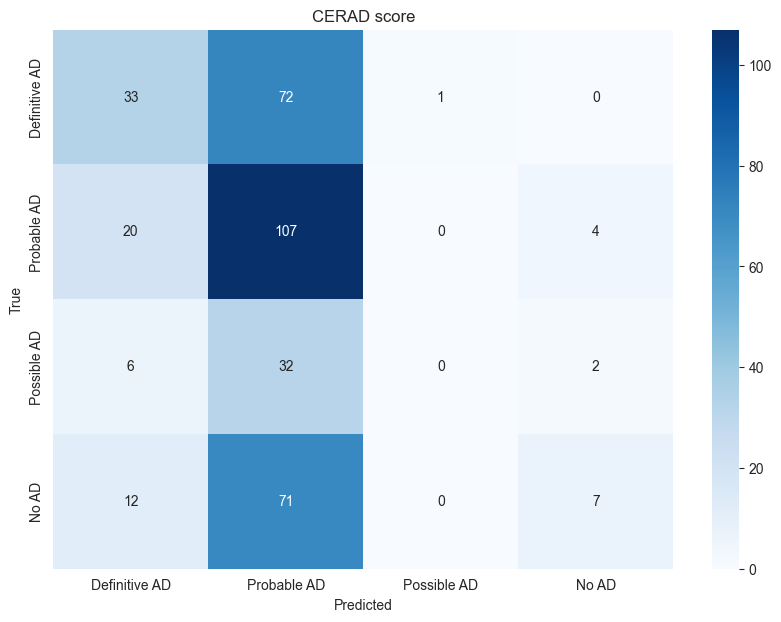

Correct cells: 
1     5538
6     4004
2     3728
4     3299
5     2356
7     1621
3     1617
11    1599
8     1223
12    1008
9      920
16     691
14     537
0      402
10     394
15     350
17     278
13     216
Name: count, dtype: int64
Braak score counts: 
1     4377
6     3457
2     2821
4     2649
5     1981
7     1429
3     1361
11    1325
8      987
12     866
9      862
16     580
14     424
10     366
0      286
15     283
17     232
13     122
Name: count, dtype: int64
Total cells: 
1     13269
6     11280
4      7923
2      7864
5      6626
7      4424
3      4149
11     3352
8      3321
9      2669
12     1966
16     1655
0       936
14      932
15      729
17      678
10      564
13      442
Name: count, dtype: int64


In [9]:
#CERAD
from collections import Counter

correctCells = []
totalCells = []
braakScoreCells = []

pred = []
true = []

for i in range(5):
    indices = np.loadtxt(f'allTasks/data/{i+1}_CTindices.txt', dtype=int)
    ids = np.loadtxt(f'allTasks/data/{i+1}_CTtestIds.txt', dtype=str)
    model = modelList[i]
    model.eval()
    adata_subset = microglia[:, indices]
    adata_subset = adata_subset[adata_subset.obs["individualID"].isin(ids)]
    X_test = adata_subset.X

    for id in ids:
        cells = adata_subset[adata_subset.obs["individualID"] == id]
        cellTensor = torch.tensor(cells.X, dtype=torch.float32)
        braaksc = ceraddict[id]
        cell_types = cells.obs["state"].values
        true.append(braaksc)
        
        with torch.no_grad():
            output = model(cellTensor)
            pred_class = (output[0] > 0.5).sum(dim=1).numpy()
            pred_cells = output[3].argmax(dim=1).numpy()
        
        classCounts = dict(Counter(pred_class))
        if braaksc in classCounts.keys():
            predMax = classCounts[braaksc]
        else:
            predMax = 0
        #predMax = classCounts[braaksc]
        guess = max(classCounts, key=classCounts.get)
        
        pred.append(guess)
        
        if guess in classCounts.keys():
            guessCount = classCounts[guess]
        else:
            guessCount = 0
        total = sum(classCounts.values())
        
        #create mask of for which cells braak score is precicted correctly
        mask = (pred_class == braaksc)
        
        cellacc = (pred_cells == cell_types).sum()
        if guess == braaksc:
    
            # print(f"ID: {id}, Braak score: {braaksc}, Predicted score: {guess}, Count: {predMax}/{total} ({predMax/total:.2%}), Cell type accuracy: {cellacc}/{len(cell_types)} ({cellacc/len(cell_types):.2%})")
            
    
            correctCells.extend(pred_cells)
        braakScoreCells.extend(pred_cells[mask])
        totalCells.extend(pred_cells)
    del adata_subset, X_test, cellTensor, output, pred_class, pred_cells 
plot_confusion_matrix(true, pred, ["Definitive AD", "Probable AD", "Possible AD", "No AD"], "CERAD score")

# correctCounts = pd.Series(correctCells).value_counts()
# totalCounts = pd.Series(totalCells).value_counts()
# braakScoreCounts = pd.Series(braakScoreCells).value_counts()
# # print("Correct counts", correctCounts)
# # print("Total counts", totalCounts)
# 
# print(f"Correct cells: \n{correctCounts}")
# print(f"Braak score counts: \n{braakScoreCounts}")
# print(f"Total cells: \n{totalCounts}")

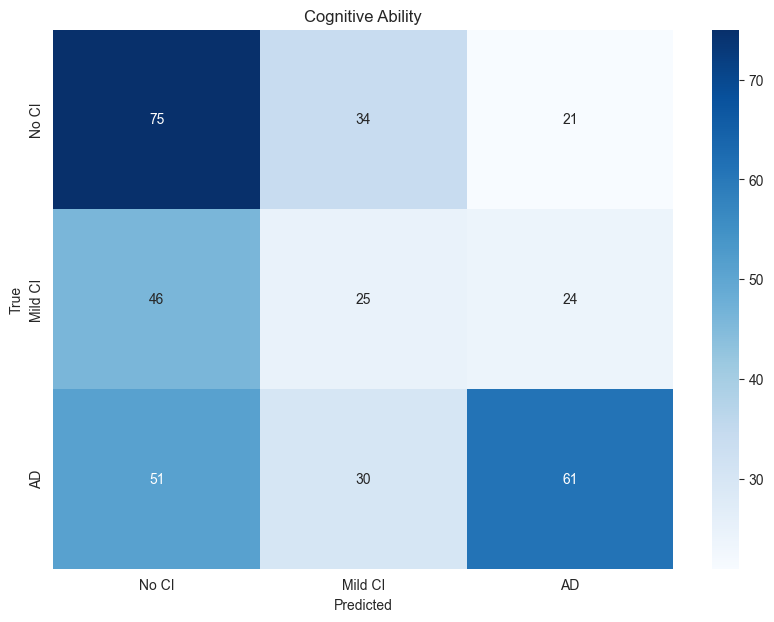

In [11]:
#COGDX
from collections import Counter

correctCells = []
totalCells = []
braakScoreCells = []

pred = []
true = []

for i in range(5):
    indices = np.loadtxt(f'allTasks/data/{i+1}_CTindices.txt', dtype=int)
    ids = np.loadtxt(f'allTasks/data/{i+1}_CTtestIds.txt', dtype=str)
    model = modelList[i]
    model.eval()
    adata_subset = microglia[:, indices]
    adata_subset = adata_subset[adata_subset.obs["individualID"].isin(ids)]
    X_test = adata_subset.X

    for id in ids:
        cells = adata_subset[adata_subset.obs["individualID"] == id]
        cellTensor = torch.tensor(cells.X, dtype=torch.float32)
        braaksc = cogdxdict[id]
        cell_types = cells.obs["state"].values
        true.append(braaksc)
        
        
        with torch.no_grad():
            output = model(cellTensor)
            pred_class = (output[2] > 0.5).sum(dim=1).numpy()
            pred_cells = output[3].argmax(dim=1).numpy()
        
        classCounts = dict(Counter(pred_class))
        if braaksc in classCounts.keys():
            predMax = classCounts[braaksc]
        else:
            predMax = 0
        #predMax = classCounts[braaksc]
        guess = max(classCounts, key=classCounts.get)
        pred.append(guess)
        
        if guess in classCounts.keys():
            guessCount = classCounts[guess]
        else:
            guessCount = 0
        total = sum(classCounts.values())
        
        #create mask of for which cells braak score is precicted correctly
        mask = (pred_class == braaksc)
        
        cellacc = (pred_cells == cell_types).sum()
        if guess == braaksc:
    
            # print(f"ID: {id}, Braak score: {braaksc}, Predicted score: {guess}, Count: {predMax}/{total} ({predMax/total:.2%}), Cell type accuracy: {cellacc}/{len(cell_types)} ({cellacc/len(cell_types):.2%})")
            
    
            correctCells.extend(pred_cells)
        braakScoreCells.extend(pred_cells[mask])
        totalCells.extend(pred_cells)
    del adata_subset, X_test, cellTensor, output, pred_class, pred_cells 
plot_confusion_matrix(true, pred, ["No CI", "Mild CI", "AD"], "Cognitive Ability")

# correctCounts = pd.Series(correctCells).value_counts()
# totalCounts = pd.Series(totalCells).value_counts()
# braakScoreCounts = pd.Series(braakScoreCells).value_counts()
# # print("Correct counts", correctCounts)
# # print("Total counts", totalCounts)
# 
# print(f"Correct cells: \n{correctCounts}")
# print(f"Braak score counts: \n{braakScoreCounts}")
# print(f"Total cells: \n{totalCounts}")

In [23]:
# select all the cells of type 10, and then print the amount of cells per individualID
type10 = microglia[microglia.obs["state"] == "Mic.15"]
print(type10)

View of AnnData object with n_obs × n_vars = 1383 × 4000
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'


In [24]:
#print the amount of cells per individualID
type10_counts = type10.obs["individualID"].value_counts()
print(type10_counts)

individualID
R1028639    454
R1547566    199
R7483736    103
R7993799     80
R7738727     50
           ... 
R7304869      1
R1933335      1
R6070702      1
R4388056      1
R1969233      1
Name: count, Length: 183, dtype: int64
